<a href="https://colab.research.google.com/github/Julianpucheta/OptimalControl/blob/main/Pontryagin%20minimum%20principle/Control_CyO_Pendulo_MH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Solución del péndulo invertido con control y observador calculado empleando el método de MH

El método MH está desarrollado en el artículo titulado "Controlador óptimo con observación de estados basado en el principio del máximo de Pontryagin de bajo costo computacional" [éste](https://riaa-tecno.unca.edu.ar/handle/123456789/1193). Disponible en éste [Repositorio](https://riaa-tecno.unca.edu.ar/bitstream/handle/123456789/1193/REVISTA%20CODINOA%20N%c2%ba%209_%20%28623-629%29%28PUCHETA%29.pdf?sequence=1&isAllowed=y).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig, inv, solve_lyapunov
from numpy.linalg import matrix_power

# System parameters
m = 0.1  # mass of pendulum
Fricc = 0.1  # friction coefficient
long = 0.6  # pendulum length
g = 9.8  # gravity
M = 0.5  # mass of cart
# System matrices (linearized model)
Mat_A = np.array([[0, 1, 0, 0],
                  [0, -Fricc/M, -m*g/M, 0],
                  [0, 0, 0, 1],
                  [0, Fricc/(long*M), g*(m+M)/(long*M), 0]],dtype=np.float64)
Mat_B = np.array([[0], [1/M], [0], [-1/(long*M)]],dtype=np.float64)
Mat_C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]],dtype=np.float64)  # Output: position and angle

# Augmented system for integral control
Mat_Aa = np.vstack([np.hstack([Mat_A, np.zeros((4, 1))]),
                    np.hstack([-Mat_C[0, :], [0]])])
Mat_Ba = np.vstack([Mat_B, [0]])

# Controllability matrix
Mat_M = np.hstack([Mat_Ba, Mat_Aa @ Mat_Ba, matrix_power(Mat_Aa, 2) @ Mat_Ba,
                   matrix_power(Mat_Aa, 3) @ Mat_Ba, matrix_power(Mat_Aa, 4) @ Mat_Ba])

# Controller design (pole placement)
auto_val = eig(Mat_Aa)[0]
c_ai = np.poly(auto_val)
Mat_W = np.array([[c_ai[4], c_ai[3], c_ai[2], c_ai[1], 1],
                  [c_ai[3], c_ai[2], c_ai[1], 1, 0],
                  [c_ai[2], c_ai[1], 1, 0, 0],
                  [c_ai[1], 1, 0, 0, 0],
                  [1, 0, 0, 0, 0]])
Mat_T = Mat_M @ Mat_W
A_controlable = inv(Mat_T) @ Mat_Aa @ Mat_T

# Desired characteristic polynomial coefficients
# alfa_ia = [1, 10.724, 37.126, 48.193, 32.590, 10.330]
# pol = np.flip(alfa_ia[1:6]) - c_ai[1:6]

a5 = -A_controlable[4, 0]
a4 = -A_controlable[4, 1]
a3 = -A_controlable[4, 2]
a2 = -A_controlable[4, 3]
a1 = -A_controlable[4, 4]

# LQR controller gains
R = 1e2
q5 = 1e5
q4 = 1e5
q3 = 1e5
q2 = 1e3
q1 = 1e1
Q = np.diag([q1, q2, q3, q4, q5])

p1 = 0.5 * (-4*a5*R + np.sqrt((4*a5*R)**2 + 16*q1*R))
p2 = 0.5 * (-4*a4*R + np.sqrt((4*a4*R)**2 + 16*q2*R))
p3 = 0.5 * (-4*a3*R + np.sqrt((4*a3*R)**2 + 16*q3*R))
p4 = 0.5 * (-4*a2*R + np.sqrt((4*a2*R)**2 + 16*q4*R))
p5 = 0.5 * (-3*a1*R + np.sqrt((3*a1*R)**2 + 8*q5*R))

Ka = np.array([p1, p2, p3, p4, p5]) / (2*R) @ inv(Mat_T)
K = Ka[:4]
KI = -Ka[4]
print("Controller Poles:")
print(eig(Mat_Aa - Mat_Ba @ Ka.reshape(1, -1))[0])

Controller Poles:
[-20.68664708+0.j          -0.04927408+0.09396393j
  -0.04927408-0.09396393j  -0.81299382+0.83485506j
  -0.81299382-0.83485506j]


In [52]:
print("MH Controller value:")
print(Ka)

MH Controller value:
[-9.680441816843437e-02 -1.073788209125126e+00 -1.709937289889659e+01
 -7.307627790864949e+00  9.680441816879774e-03]


In [33]:
# Observer design (LQR)
Mat_Adual = Mat_A.T
Mat_Bdual = Mat_C.T
Mat_Cdual = Mat_B.T
Qdual = np.diag([1, 1, 1, 10000])
Rdual = 0.01 * np.eye(2)
Ha = np.vstack([np.hstack([Mat_Adual, -Mat_Bdual @ inv(Rdual) @ Mat_Bdual.T]),
                np.hstack([-Qdual, -Mat_Adual.T])])
D, V = eig(Ha)
n = Ha.shape[0]
MX1X2 = V[:, np.real(D) < 0]
MX1 = MX1X2[:n//2, :]
MX2 = MX1X2[n//2:, :]
P = np.real(MX2 @ inv(MX1))
Ko1 = (inv(Rdual) @ Mat_Bdual.T @ P).T
print("LQR Observer Poles:")
print(eig(Mat_A - Ko1 @ Mat_C)[0])

LQR Observer Poles:
[ -1.043959426673863 +0.j
  -9.947381050239205 +0.j
 -23.12779588975478 +21.570699182913735j
 -23.12779588975478 -21.570699182913735j]


## Cálculo del Observador empleando el método de MH

In [39]:
# Observer design (MH)
h_ = 1e-9 * np.array([[-1], [-1]], dtype=np.float64)
Mat_Bdual = Mat_C.T @ h_
Mat_M = np.hstack([Mat_Bdual, Mat_Adual @ Mat_Bdual, matrix_power(Mat_Adual, 2) @ Mat_Bdual,
                   matrix_power(Mat_Adual, 3) @ Mat_Bdual])
auto_val = eig(Mat_Adual)[0]
c_ai = np.poly(auto_val)
Mat_W = np.array([[c_ai[3], c_ai[2], c_ai[1], 1],
                  [c_ai[2], c_ai[1], 1, 0],
                  [c_ai[1], 1, 0, 0],
                  [1, 0, 0, 0]])
Mat_T = Mat_M @ Mat_W
A_controlable = inv(Mat_T) @ Mat_Adual @ Mat_T
a4 = -A_controlable[3, 0]
a3 = -A_controlable[3, 1]
a2 = -A_controlable[3, 2]
a1 = -A_controlable[3, 3]
Qdual = np.diag([1, 10000, 100000, 100])
Ro = 0.1
q4 = Qdual[3, 3]
q3 = Qdual[2, 2]
q2 = Qdual[1, 1]
q1 = Qdual[0, 0]
p1 = 0.5 * (-4*a4*Ro + np.sqrt((4*a4*Ro)**2 + 16*q1*Ro))
p2 = 0.5 * (-4*a3*Ro + np.sqrt((4*a3*Ro)**2 + 16*q2*Ro))
p3 = 0.5 * (-4*a2*Ro + np.sqrt((4*a2*Ro)**2 + 16*q3*Ro))
p4 = 0.5 * (-3*a1*Ro + np.sqrt((3*a1*Ro)**2 + 8*q4*Ro))
ko_ = np.array([p1, p2, p3, p4]) / (2*Ro) @ inv(Mat_T)
Ko = (h_@ko_.reshape(-1, 1).T).T
print("MH Observer Poles:")
print(eig(Mat_A - Ko @ Mat_C)[0])

MH Observer Poles:
[-1.104641481996848e+01+29.514949993352676j
 -1.104641481996848e+01-29.514949993352676j
 -1.033735925104159e-02 +0.j
 -3.080158854449354e-01 +0.j               ]


In [53]:
print("MH Observer value:")
print(Ko)

MH Observer value:
[[  -9.909110587140498   -9.909110587140498]
 [-111.1608941818704   -111.1608941818704  ]
 [  32.12029347177341    32.12029347177341 ]
 [1126.5107191611235   1126.5107191611235  ]]


## Simulación del controlador con el observador, desde cualquier condición inicial para el ángulo $\phi_0$ [$-\pi, \pi$].

[ 1.007449984110522e+02  4.434250415195482e-03 -9.002707966824459e-04
  8.359439585213417e-05]


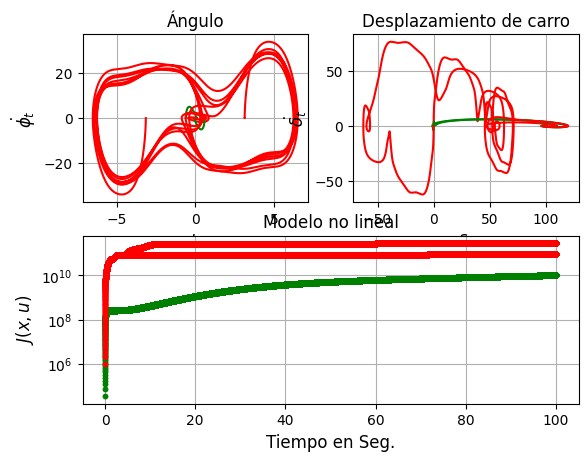

In [45]:
# Simulation
T_CI = 4
# Set precision in NumPy
np.set_printoptions(precision=15)
# Ensure arrays are of type float64
# array = np.array([1.0, 2.0, 3.0], dtype=np.float64)
# Simulation parameters
h = 1e-3  # time step
tiempo = int(100 / h)  # total time steps
t = np.arange(0, (tiempo + 1) * h, h)  # time vector
ref = 100.  # reference position
# Initial conditions
# alfa = np.zeros(tiempo + 1, dtype=np.float64)
omega = np.zeros(tiempo + 1, dtype=np.float64)
p_p = np.zeros(tiempo + 1, dtype=np.float64)
u = np.zeros(tiempo + 1, dtype=np.float64)
p = np.zeros(tiempo + 1, dtype=np.float64)
psi = np.zeros(tiempo + 1, dtype=np.float64)
Jn = np.zeros(tiempo + 1, dtype=np.float64)
y_sal = np.zeros(tiempo + 1, dtype=np.float64)
psi = np.zeros(tiempo + 1, dtype=np.float64)
Mat_datop = np.zeros((T_CI, tiempo + 1))
Mat_datop_p = np.zeros((T_CI, tiempo + 1))
Mat_datoalfa = np.zeros((T_CI, tiempo + 1))
Mat_datoomega = np.zeros((T_CI, tiempo + 1))
Mat_datou = np.zeros((T_CI, tiempo + 1))
plt.figure(2)
for ci in range(T_CI):
    x_hat = np.zeros(4, dtype=np.float64)
    x_hat_p = np.zeros(4, dtype=np.float64)
    Jn[0] = 0.
    omega[0] = 0.
    p_p[0] = 0.
    u[0] = 0.
    p[0] = 0.
    alfa = np.zeros(tiempo + 1, dtype=np.float64)
    if ci == 0:
      alfa[0] = np.pi
      color = 'r'
    if ci== 1:
      alfa[0]=.6
      color='g'
    if ci== 2:
      alfa[0]=-.6
      color='g'
    if ci== 3:
      alfa[0]=-np.pi
      color='r'
    colorc = color + '.'
    Mat_datop[ci, 0] = p[0]
    Mat_datop_p[ci, 0] = p_p[0]
    Mat_datoalfa[ci, 0] = alfa[0]
    Mat_datoomega[ci, 0] = omega[0]
    Mat_datou[ci, 0] = u[0]
    i = 0
    while i < tiempo:
        estado = np.array([p[i], p_p[i], alfa[i], omega[i]], dtype=np.float64)
        psi_p = ref - Mat_C[0, :] @ estado
        psi[i + 1] = psi[i] + psi_p * h
        u[i] = -K @ x_hat + KI * psi[i + 1]
        # u[i] = -K @ estado + KI * psi[i + 1]
        # Nonlinear dynamics
        tita_pp = 0.
        p_pp = (1/(M + m)) * (u[i] - m*long*tita_pp*np.cos(alfa[i]) +
               m*long*omega[i]**2*np.sin(alfa[i]) - Fricc*p_p[i])
        tita_pp = (1/long) * (g*np.sin(alfa[i]) - p_pp*np.cos(alfa[i]))

        p_p[i + 1]  = p_p[i] + h * p_pp
        p[i + 1]    = p[i] + h * p_p[i]
        omega[i + 1]= omega[i] + h * tita_pp
        alfa[i + 1] = alfa[i] + h * omega[i]

        Y_ = Mat_C @ estado
        y_sal[i] = Y_[0]
        Jn[i + 1] = Jn[i] + estado.T @ Q[:4, :4] @ estado + u[i]**2 * R

        # Observer
        y_sal_O = Mat_C @ x_hat
        x_hatp = Mat_A @ x_hat + Mat_B.flatten() * u[i] + Ko1 @ (Y_ - y_sal_O)
        # x_hatp = Mat_A @ x_hat + Mat_B.flatten() * u[i] + Ko @ (Y_ - y_sal_O)
        x_hat = x_hat + h * x_hatp
        i += 1
    u[i] = -K @ x_hat + KI * psi[i]
    Mat_datop[ci, :] = p
    Mat_datop_p[ci, :] = p_p
    Mat_datoalfa[ci, :] = alfa
    Mat_datoomega[ci, :] = omega
    Mat_datou[ci, :] = u
    # Plot phase portraits
    plt.subplot(2, 2, 1)
    plt.plot(alfa, omega, color)
    plt.grid(True)
    plt.title('Ángulo', fontsize=12)
    plt.xlabel(r'$\phi_t$', fontsize=12)
    plt.ylabel(r'$\dot{\phi_t}$', fontsize=12)
    plt.subplot(2, 2, 2)
    plt.plot(p, p_p, color)
    plt.grid(True)
    plt.title('Desplazamiento de carro', fontsize=12)
    plt.xlabel(r'$\delta_t$', fontsize=12)
    plt.ylabel(r'$\dot{\delta_t}$', fontsize=12)
    plt.subplot(2, 1, 2)
    plt.semilogy(t, Jn, colorc)
    plt.grid(True)
    plt.title('Modelo no lineal', fontsize=12)
    plt.xlabel('Tiempo en Seg.', fontsize=12)
    plt.ylabel(r'$J(x,u)$', fontsize=12)
print(x_hat)

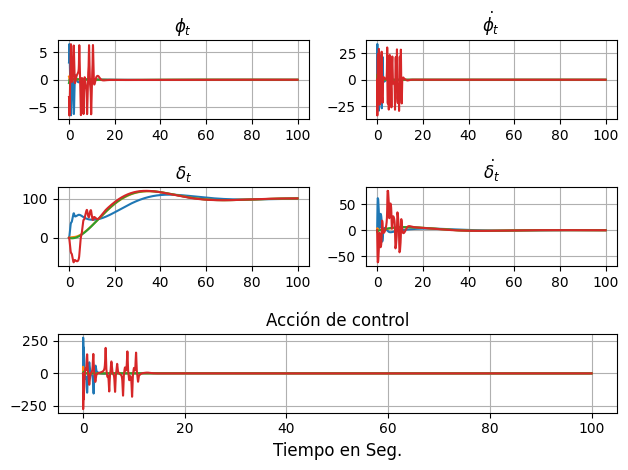

In [46]:
# Time-domain plots
plt.figure(1)
plt.subplot(3, 2, 1)
plt.plot(t, Mat_datoalfa.T)
plt.grid(True)
plt.title(r'$\phi_t$', fontsize=12)
plt.subplot(3, 2, 2)
plt.plot(t, Mat_datoomega.T)
plt.grid(True)
plt.title(r'$\dot{\phi_t}$', fontsize=12)
plt.subplot(3, 2, 3)
plt.plot(t, Mat_datop.T)
plt.grid(True)
plt.title(r'$\delta_t$', fontsize=12)
plt.subplot(3, 2, 4)
plt.plot(t, Mat_datop_p.T)
plt.grid(True)
plt.title(r'$\dot{\delta_t}$', fontsize=12)
plt.subplot(3, 1, 3)
plt.plot(t, Mat_datou.T)
plt.grid(True)
plt.title('Acción de control', fontsize=12)
plt.xlabel('Tiempo en Seg.', fontsize=12)
plt.tight_layout()
plt.show()

# Conclusiones

Se ha mostrado el desempeño de un controlador con observación de estados desarrollado por investigadores que trabajan en la temática.